In [1]:
import sys
sys.path.append('../python') #Path to load WI_Solver_Utils.py
import WI_Solver_utils
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import trange
from WI_Solver_utils import InflatonModel, Background, Perturbations, Scalar_Dissipation_Function
matplotlib.rcParams.update({'errorbar.capsize': 2})
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams.update({'legend.title_fontsize':5.5})
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

In [2]:
####################################################################
#   Define tau array over which we solved for the perturbations:   #
####################################################################
"""Recall: \tau=\ln(z)=\ln(k/(aH))"""

tau_ini = 6
tau_end = -1
N_Qvar = 400000
N_Qconst=100000
dtau_Qvar = (tau_end - tau_ini) / N_Qvar # DT is a negative quantity as expected since tau is decreasing over time
taus_Qvar = np.linspace(tau_ini, tau_end, N_Qvar)
dtau_Qconst = (tau_end - tau_ini) / N_Qconst
taus_Qconst = np.linspace(tau_ini, tau_end, N_Qconst)

#################################
#   Define Global Parameters:   #
#################################

Mpl = 1 # Everything is in Plank units M_{pl}
g = 228.27  # SUSY relativistic degrees of freedom
a1 = np.pi**2/30*g

Neinflation=60 #Number of e-folds of after CMB horizon crossing
Ne_pert= 10 # Number of e-folds before CMB horizon crossing
Nruns=1024 #How many runs we average over to compute the perturbations
MPs_bool='wo' #without metric perturbations
epsH_etaH_bool='wo' #negligible epsH and etaH


cm_cases=[[3,0],[3,2]]

In [3]:
#######################################################################
#   Define the type of inflaton potential and its main parammeters:   #
#######################################################################

potential_type='quartic'

lv = 10**(-14)  # value of lambda

Model = InflatonModel('monomial', [lv, 4], g, a1, Mpl)


################################################
#   Initial conditions on \phi0 and Q array:   #
################################################

"""
Note here we load previously computed initial conditions that guarantee N_e= Neinflation + 8 efolds of inflation.
To see how these were computed, check out the notebook "ICs_ph0.ipynb"
"""

ICs_Q0_ph0_Qconst=np.loadtxt('../ICS_ph0-Q0s/ICS_ph0-Q0s_'+potential_type+'_Ne'+str(int(Neinflation))+'.txt')
Q0s_Qconst=ICs_Q0_ph0_Qconst[:,0]
ph0s_Qconst=ICs_Q0_ph0_Qconst[:,1]

ICs_Q0_ph0_Qvar_c3m2=np.loadtxt('../ICS_ph0-Q0s/ICS_ph0-Q0s_'+potential_type+'_Ne'+str(int(Neinflation))+'_c3m2.txt')
Q0s_Qvar_c3m2=ICs_Q0_ph0_Qvar_c3m2[:,0]
ph0s_Qvar_c3m2=ICs_Q0_ph0_Qvar_c3m2[:,1]

ICs_Q0_ph0_Qvar_c3m0=np.loadtxt('../ICS_ph0-Q0s/ICS_ph0-Q0s_'+potential_type+'_Ne'+str(int(Neinflation))+'_c3m0.txt')
Q0s_Qvar_c3m0=ICs_Q0_ph0_Qvar_c3m0[:,0]
ph0s_Qvar_c3m0=ICs_Q0_ph0_Qvar_c3m0[:,1]

########################################################################
#   Compute the Analytic approximation of the Power spectrum for c=0   #
########################################################################

R2_analytic_Qconst, R2_analytic_Qvar_c3m2, R2_analytic_Qvar_c3m0=np.zeros(len(Q0s_Qconst)),np.zeros(len(Q0s_Qvar_c3m2)),np.zeros(len(Q0s_Qvar_c3m0))
for i in trange(len(Q0s_Qvar_c3m2)):
    Bg_Qconst=Background(Model,ph0s_Qconst[i],Q0s_Qconst[i])
    R2_analytic_Qconst[i]=Bg_Qconst.analytic_power_spectrum(int(Neinflation+Ne_pert), 10**(6), taus_Qconst, Neinflation)
    Bg_Qvar_c3m2=Background(Model,ph0s_Qvar_c3m2[i],Q0s_Qvar_c3m2[i],Qconstant=False,Qvariables=[3,2])
    R2_analytic_Qvar_c3m2[i]=Bg_Qvar_c3m2.analytic_power_spectrum(int(Neinflation+Ne_pert), 10**(6), taus_Qvar, Neinflation)
    Bg_Qvar_c3m0=Background(Model,ph0s_Qvar_c3m0[i],Q0s_Qvar_c3m0[i],Qconstant=False,Qvariables=[3,0])
    R2_analytic_Qvar_c3m0[i]=Bg_Qvar_c3m0.analytic_power_spectrum(int(Neinflation+Ne_pert), 10**(6), taus_Qvar, Neinflation)
    del Bg_Qconst, Bg_Qvar_c3m2, Bg_Qvar_c3m0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [02:54<00:00,  3.35s/it]


In [4]:
######################################################################
# Load solutions to the perturbations equations saved in a .txt file #
######################################################################

_,R2m_Qconst_c3m2,R2std_Qconst_c3m2=np.loadtxt('../WI_PowerSpectra_data/PowerSpectra_'+str(MPs_bool)+'MPs_'+str(epsH_etaH_bool)+'epsH-etaH_'+potential_type+'_c3m2_n'+str(int(N_Qconst))+'_Nr'+str(int(Nruns))+'_Ne'+str(int(Neinflation))+'.txt')
_,R2m_Qvar_c3m2,R2std_Qvar_c3m2=np.loadtxt('../WI_PowerSpectra_data/PowerSpectra_'+str(MPs_bool)+'MPs_'+str(epsH_etaH_bool)+'epsH-etaH_'+potential_type+'_c3m2_n'+str(int(N_Qvar))+'_Nr'+str(int(Nruns))+'_Ne'+str(int(Neinflation))+'_Qvarying.txt')
_,R2m_Qconst_c3m0,R2std_Qconst_c3m0=np.loadtxt('../WI_PowerSpectra_data/PowerSpectra_'+str(MPs_bool)+'MPs_'+str(epsH_etaH_bool)+'epsH-etaH_'+potential_type+'_c3m0_n'+str(int(N_Qconst))+'_Nr'+str(int(Nruns))+'_Ne'+str(int(Neinflation))+'.txt')
_,R2m_Qvar_c3m0,R2std_Qvar_c3m0=np.loadtxt('../WI_PowerSpectra_data/PowerSpectra_'+str(MPs_bool)+'MPs_'+str(epsH_etaH_bool)+'epsH-etaH_'+potential_type+'_c3m0_n'+str(int(N_Qvar))+'_Nr'+str(int(Nruns))+'_Ne'+str(int(Neinflation))+'_Qvarying.txt')


# Comparison of G(Q) between evolving vs constant Q

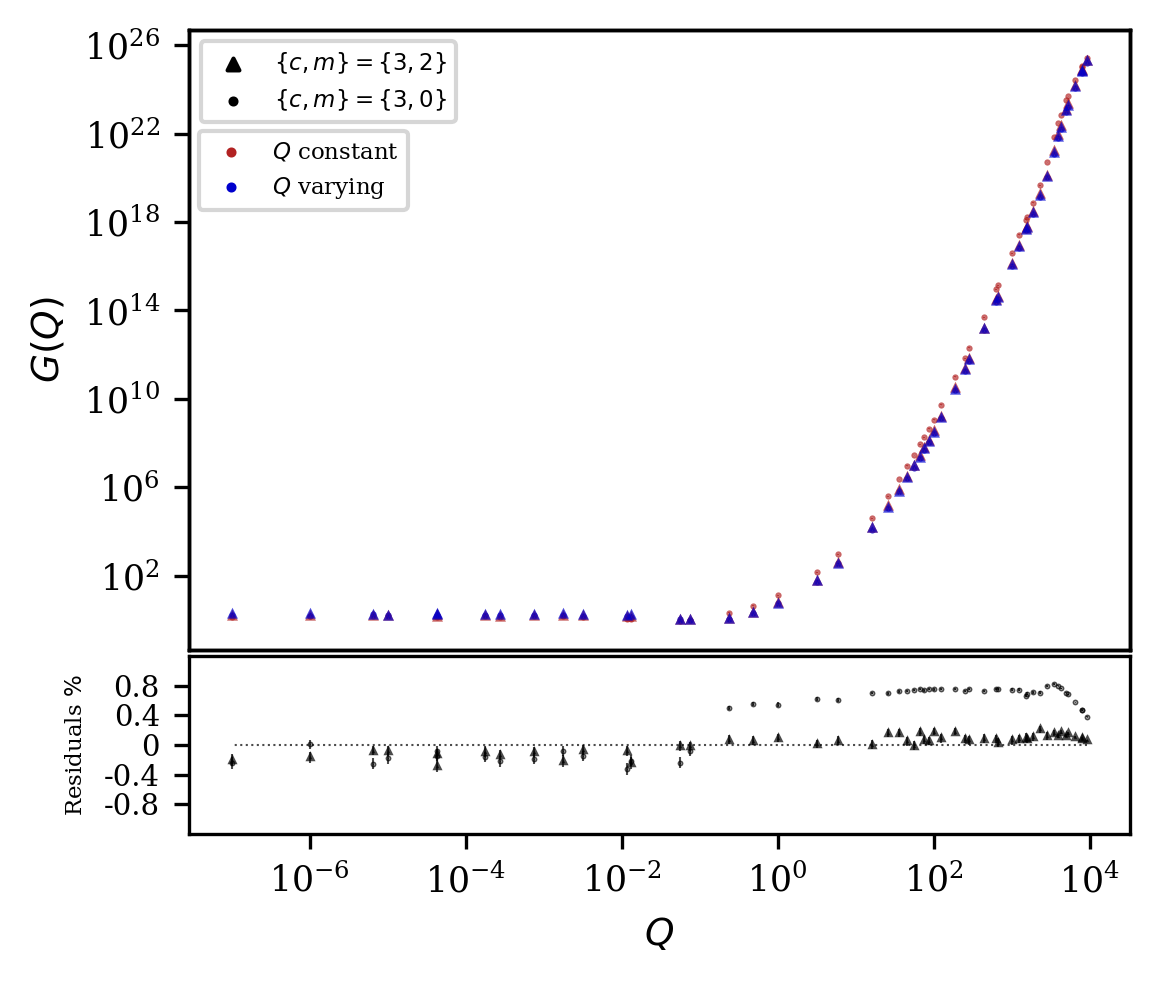

In [25]:
##########################################################################
# Function to compute residuals of the scalar dissipation function fits: #
##########################################################################

def residual_calculator(sig1,err1,sig2,err2):
    res_sig=(sig1-sig2)/sig1
    chi2=np.sum((sig1-sig2)**2/err1**2)
    res_err=np.sqrt((sig2/sig1**2*err1)**2+ (err2/sig1)**2)
    return res_sig, res_err,chi2

###################################################
#  Make Figure where I plot the data and the fit: #
###################################################

fig1=plt.figure(figsize=(4.5,3.8),dpi=300)
gs1 = GridSpec(24,20,figure=fig1)
ax1 = fig1.add_subplot(gs1[1:18,1:-1])
ax2 = fig1.add_subplot(gs1[18:-1,1:-1])
ax12 = ax1.twinx()
ax13 = ax1.twinx()

##############################
# Useful for general legend: #
##############################
models_cols_data=['firebrick','mediumblue','forestgreen']
models_cols_fits=['salmon','cyan','lime']
models_cols_fits_p=['tab:red','tab:blue']
cols_fits=['k','tab:red']
marker_Ne=['^','s','.']
ax2.set_xlabel("$Q$",fontdict={'fontsize':9,'family':'serif'})
ax1.set_ylabel("$G(Q)$",fontdict={'fontsize':9,'family':'serif'})

ax2.set_ylabel("Residuals $\%$",fontdict={'fontsize':5.5,'family':'serif'})

ax12.scatter(np.NaN,np.NaN,label='$\{c,m\}=\{3,2\}$',marker='^',s=8, c='k')
ax12.scatter(np.NaN,np.NaN,label='$\{c,m\}=\{3,0\}$',marker='.',s=8, c='k')

ax13.scatter(np.NaN,np.NaN,label=r'$Q$ constant',marker='.',s=8, c=models_cols_data[0])
ax13.scatter(np.NaN,np.NaN,label=r'$Q$ varying',marker='.',s=8, c=models_cols_data[1])

# Define the scalar dissipation function from the solution to the perturbations equations:
Gf_Qvar_c3m2=Scalar_Dissipation_Function(Model,Q0s_Qvar_c3m2,ph0s_Qvar_c3m2,R2m_Qvar_c3m2,R2std_Qvar_c3m2,Nruns,int(Neinflation+Ne_pert),10**(6),taus_Qvar,Neinflation,3,2)
_,_,GQ_sig_Qvar_c3m2,GQ_err_Qvar_c3m2=Gf_Qvar_c3m2.scalar_dissipation_function_fit(method='log',output_data=True,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic_Qvar_c3m2)
Gf_Qvar_c3m0=Scalar_Dissipation_Function(Model,Q0s_Qvar_c3m0,ph0s_Qvar_c3m0,R2m_Qvar_c3m0,R2std_Qvar_c3m0,Nruns,int(Neinflation+Ne_pert),10**(6),taus_Qvar,Neinflation,3,0)
_,_,GQ_sig_Qvar_c3m0,GQ_err_Qvar_c3m0=Gf_Qvar_c3m0.scalar_dissipation_function_fit(method='log',output_data=True,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic_Qvar_c3m0)
Gf_Qconst_c3m2=Scalar_Dissipation_Function(Model,Q0s_Qconst,ph0s_Qconst,R2m_Qconst_c3m2,R2std_Qconst_c3m2,Nruns,int(Neinflation+Ne_pert),10**(6),taus_Qconst,Neinflation,3,2)
_,_,GQ_sig_Qconst_c3m2,GQ_err_Qconst_c3m2=Gf_Qconst_c3m2.scalar_dissipation_function_fit(method='log',output_data=True,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic_Qconst)
Gf_Qconst_c3m0=Scalar_Dissipation_Function(Model,Q0s_Qconst,ph0s_Qconst,R2m_Qconst_c3m0,R2std_Qconst_c3m0,Nruns,int(Neinflation+Ne_pert),10**(6),taus_Qconst,Neinflation,3,0)
_,_,GQ_sig_Qconst_c3m0,GQ_err_Qconst_c3m0=Gf_Qconst_c3m0.scalar_dissipation_function_fit(method='log',output_data=True,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic_Qconst)

ax1.errorbar(Q0s_Qvar_c3m2,GQ_sig_Qvar_c3m2,yerr=GQ_err_Qvar_c3m2,c=models_cols_data[0],marker='.',ls='none',markersize=1,linewidth=0.5,alpha=.7)
ax1.errorbar(Q0s_Qconst,GQ_sig_Qconst_c3m2,yerr=GQ_err_Qconst_c3m2,c=models_cols_data[1],marker='.',ls='none',markersize=1,linewidth=0.5,alpha=.7)
ax1.errorbar(Q0s_Qvar_c3m0,GQ_sig_Qvar_c3m0,yerr=GQ_err_Qvar_c3m0,c=models_cols_data[0],marker='^',ls='none',markersize=1,linewidth=0.5,alpha=.7)
ax1.errorbar(Q0s_Qconst,GQ_sig_Qconst_c3m0,yerr=GQ_err_Qconst_c3m0,c=models_cols_data[1],marker='^',ls='none',markersize=1,linewidth=0.5,alpha=.7)

rsig_c3m2,rerr_c3m2,chi2_c3m2=residual_calculator(GQ_sig_Qvar_c3m2,GQ_err_Qvar_c3m2,GQ_sig_Qconst_c3m2,GQ_err_Qconst_c3m2)
ax2.errorbar(Q0s_Qvar_c3m2,rsig_c3m2,yerr=rerr_c3m2,c='k',marker='.',ls='none',markersize=.8,linewidth=0.5,alpha=.7) 
rsig_c3m0,rerr_c3m0,chi2_c3m0=residual_calculator(GQ_sig_Qvar_c3m0,GQ_err_Qvar_c3m0,GQ_sig_Qconst_c3m0,GQ_err_Qconst_c3m0)
ax2.errorbar(Q0s_Qvar_c3m0,rsig_c3m0,yerr=rerr_c3m0,c='k',marker='^',ls='none',markersize=.8,linewidth=0.5,alpha=.7) 

ax2.plot(Q0s_Qvar_c3m2,np.zeros(len(Q0s_Qvar_c3m2)),ls=':',alpha=0.7,linewidth=0.5,c='k')
ax13.get_yaxis().set_visible(False)
ax12.get_yaxis().set_visible(False)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax2.set_ylim(-1.2,1.2)
ax2.set_yticks(ticks=[-0.8,-0.4,0,0.4,0.8])
ax2.set_yticklabels([-0.8,-0.4,0,0.4,0.8], fontsize=7)
ax1.set_xticks(ticks=[])
ax12.set_xticks(ticks=[])
ax12.set_yticks(ticks=[])
ax13.set_xticks(ticks=[])
ax13.set_yticks(ticks=[])
ax12.legend(loc=2,prop={'family':'serif','size':5.5},framealpha=0.8)
ax13.legend(loc=(0.01,.71),prop={'family':'serif','size':5.5},framealpha=0.8)
plt.show()
plt.close()

# Comparison of $\Delta_{\mathcal{R}}^2$ for evolving vs constant Q

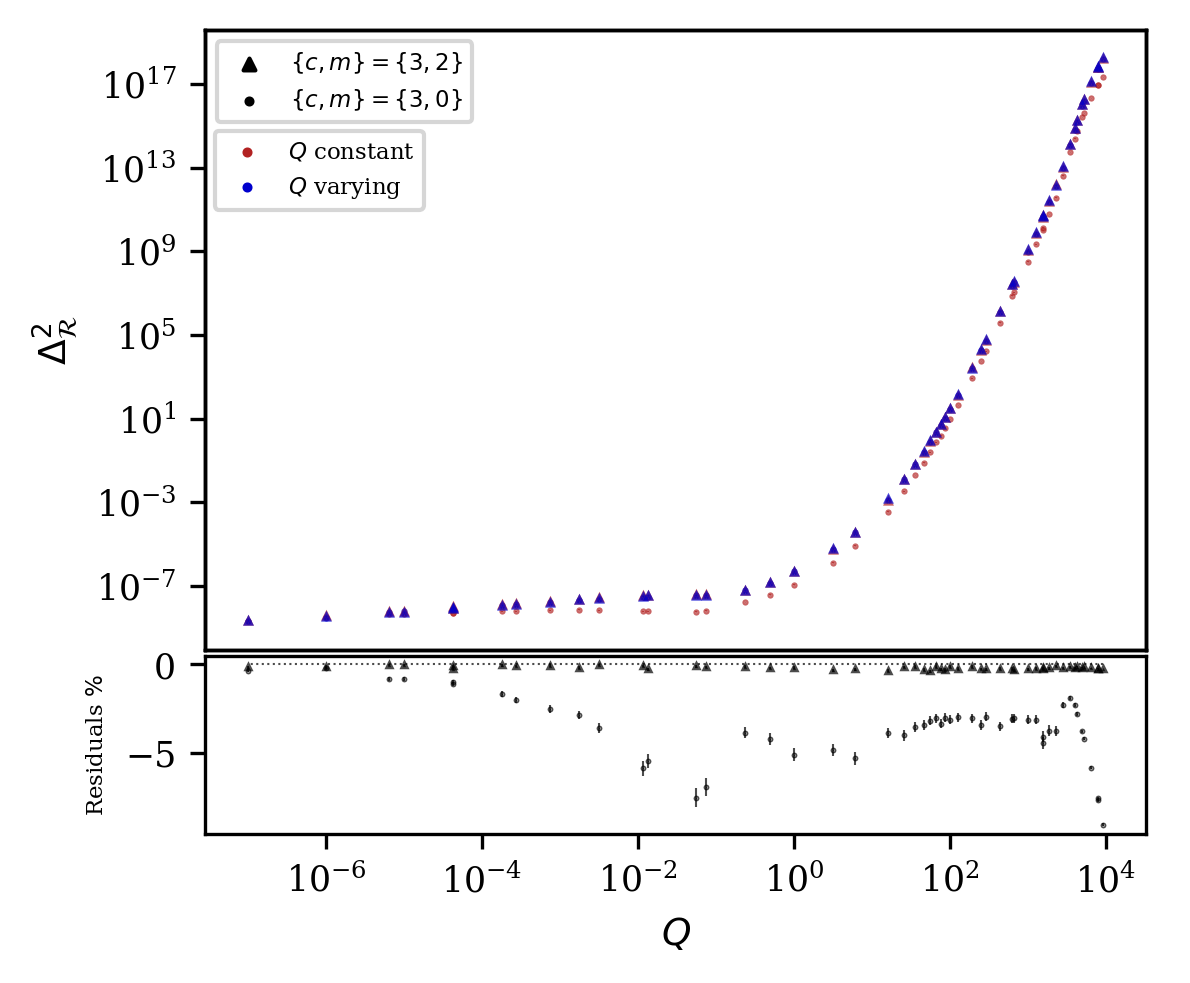

In [31]:
###################################################
#  Make Figure where I plot the data and the fit: #
###################################################

fig1=plt.figure(figsize=(4.5,3.8),dpi=300)
gs1 = GridSpec(24,20,figure=fig1)
ax1 = fig1.add_subplot(gs1[1:18,1:-1])
ax2 = fig1.add_subplot(gs1[18:-1,1:-1])
ax12 = ax1.twinx()
ax13 = ax1.twinx()

##############################
# Useful for general legend: #
##############################
models_cols_data=['firebrick','mediumblue','forestgreen']
models_cols_fits=['salmon','cyan','lime']
models_cols_fits_p=['tab:red','tab:blue']
cols_fits=['k','tab:red']
marker_Ne=['^','s','.']
ax2.set_xlabel("$Q$",fontdict={'fontsize':9,'family':'serif'})
ax1.set_ylabel("$\Delta^2_{\mathcal{R}}$",fontdict={'fontsize':9,'family':'serif'})

ax2.set_ylabel("Residuals $\%$",fontdict={'fontsize':5.5,'family':'serif'})

ax12.scatter(np.NaN,np.NaN,label='$\{c,m\}=\{3,2\}$',marker='^',s=8, c='k')
ax12.scatter(np.NaN,np.NaN,label='$\{c,m\}=\{3,0\}$',marker='.',s=8, c='k')

ax13.scatter(np.NaN,np.NaN,label=r'$Q$ constant',marker='.',s=8, c=models_cols_data[0])
ax13.scatter(np.NaN,np.NaN,label=r'$Q$ varying',marker='.',s=8, c=models_cols_data[1])

###########################################################################
### Comparison of Power Spectra, normalized to 2.1*10^{-9} at Q=10^{-7} ###
###########################################################################
R2_cmb=2.1*10**(-9)
ax1.errorbar(Q0s_Qvar_c3m2,R2m_Qvar_c3m2*R2_cmb/R2m_Qvar_c3m2[-1],yerr=R2std_Qvar_c3m2/np.sqrt(Nruns)*R2_cmb/R2m_Qvar_c3m2[-1],c=models_cols_data[0],marker='.',ls='none',markersize=1,linewidth=0.5,alpha=.7)
ax1.errorbar(Q0s_Qconst,R2m_Qconst_c3m2*R2_cmb/R2m_Qconst_c3m2[-1],yerr=R2std_Qconst_c3m2/np.sqrt(Nruns)*R2_cmb/R2m_Qconst_c3m2[-1],c=models_cols_data[1],marker='.',ls='none',markersize=1,linewidth=0.5,alpha=.7)
ax1.errorbar(Q0s_Qvar_c3m0,R2m_Qvar_c3m0*R2_cmb/R2m_Qvar_c3m0[-1],yerr=R2std_Qvar_c3m0/np.sqrt(Nruns)*R2_cmb/R2m_Qvar_c3m0[-1],c=models_cols_data[0],marker='^',ls='none',markersize=1,linewidth=0.5,alpha=.7)
ax1.errorbar(Q0s_Qconst,R2m_Qconst_c3m0*R2_cmb/R2m_Qconst_c3m0[-1],yerr=R2std_Qconst_c3m0/np.sqrt(Nruns)*R2_cmb/R2m_Qconst_c3m0[-1],c=models_cols_data[1],marker='^',ls='none',markersize=1,linewidth=0.5,alpha=.7)

rsig_c3m2,rerr_c3m2,chi2_c3m2=residual_calculator(R2m_Qvar_c3m2,R2std_Qvar_c3m2/np.sqrt(Nruns),R2m_Qconst_c3m2,R2std_Qconst_c3m2/np.sqrt(Nruns))
ax2.errorbar(Q0s_Qvar_c3m2,rsig_c3m2,yerr=rerr_c3m2,c='k',marker='.',ls='none',markersize=.8,linewidth=0.5,alpha=.7) 
rsig_c3m0,rerr_c3m0,chi2_c3m0=residual_calculator(R2m_Qvar_c3m0,R2std_Qvar_c3m0/np.sqrt(Nruns),R2m_Qconst_c3m0,R2std_Qconst_c3m0/np.sqrt(Nruns))
ax2.errorbar(Q0s_Qvar_c3m0,rsig_c3m0,yerr=rerr_c3m0,c='k',marker='^',ls='none',markersize=.8,linewidth=0.5,alpha=.7) 


ax2.plot(Q0s_Qvar_c3m2,np.zeros(len(Q0s_Qvar_c3m2)),ls=':',alpha=0.7,linewidth=0.5,c='k')
ax13.get_yaxis().set_visible(False)
ax12.get_yaxis().set_visible(False)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')
#ax2.set_ylim(-1.2,1.2)
#ax2.set_yticks(ticks=[-0.8,-0.4,0,0.4,0.8])
#ax2.set_yticklabels([-0.8,-0.4,0,0.4,0.8], fontsize=7)
ax1.set_xticks(ticks=[])
ax12.set_xticks(ticks=[])
ax12.set_yticks(ticks=[])
ax13.set_xticks(ticks=[])
ax13.set_yticks(ticks=[])
ax12.legend(loc=2,prop={'family':'serif','size':5.5},framealpha=0.8)
ax13.legend(loc=(0.01,.71),prop={'family':'serif','size':5.5},framealpha=0.8)
plt.show()
plt.close()